# Libs Import


In [1]:
# %load_ext autoreload
# %autoreload 2
from typing import Optional, Tuple, Literal
import os
import sys
import time
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import jax
import jax.numpy as jnp
import jax.random as jrandom 
import jax.nn as jnn
import equinox as eqx
import optax
from tqdm.notebook import tqdm
from collections import defaultdict
from functools import partial
from scipy.stats import spearmanr, pearsonr

jax.config.update('jax_enable_x64', True)
jax.config.update('jax_platforms', 'cpu')

# jax.config.update('jax_check_tracer_leaks', True) 
sys.path.append("../../..")
from lib.ml.icnn_modules import ProbStackedICNNImputer, ImputerMetrics, ProbICNNImputerTrainer, ICNNObsDecoder, StandardICNNImputerTrainer
import lib.ehr.example_datasets.mimiciv_aki as m4aki
from lib.ehr.tvx_ehr import TVxEHR
from lib.utils import modified_environ, write_config, append_params_to_zip, zip_members
 

In [2]:
# ?pub_ready_plots.get_mpl_rcParams
# !pip install pub-ready-plots

In [3]:
import pub_ready_plots
from pub_ready_plots import get_mpl_rcParams
rc_params, fig_width_in, fig_height_in = pub_ready_plots.get_mpl_rcParams(
    width_frac=1,  # between 0 and 1
    height_frac=0.2,  # between 0 and 1
    layout="jmlr"  # or "iclr", "neurips", "poster-portrait", "poster-landscape"
)
rc_params['figure.constrained_layout.use'] = True

# rc_params['font.size'] = 10
# rc_params['axes.titlesize'] = 12
# rc_params['axes.labelsize'] = 10
# rc_params['legend.fontsize'] = 10

plt.rcParams.update(rc_params)


# Experiment Defnitions

In [4]:
RESULTS_DIR = 'icnn_results_A'
EXP_DIR = {
    'ICNN_LN': 'experiment_snapshots_mimic_ProbStackedICNN_lognormal',
    'ICNN_NLN': 'experiment_snapshots_mimic_ProbStackedICNN_lognormal_normalised',
    'ICNN_KL': 'experiment_snapshots_mimic_ProbStackedICNN_kl',
    'ICNN_NKL': 'experiment_snapshots_mimic_ProbStackedICNN_kl_normalised',    
    'ICNN_MSE': 'experiment_snapshots_mimic_ProbStackedICNN_mse',
    'ICNN_NMSE': 'experiment_snapshots_mimic_ProbStackedICNN_mse_normalised',
}
PROP_MODELS = ('ICNN_LN', 'ICNN_NLN', 'ICNN_KL', 'ICNN_NKL')
DET_MODELS = ('ICNN_MSE', 'ICNN_NMSE')

EXP = 'ICNN_NLN'

# Data Loading

## First Time Loading and Writing to Disk

In [6]:
# tvx = m4aki.TVxAKIMIMICIVDataset.load('/home/asem/GP/ehr-data/mimic4aki-cohort/tvx_aki.h5')

In [7]:
# obs = [adm.observables  for subject in tvx0.subjects.values() for adm in subject.admissions]
# adm_id = sum(([adm.admission_id] * len(adm.observables.time)  for subject in tvx0.subjects.values() for adm in subject.admissions), [])
# subj_id = sum(([subject.subject_id] * len(adm.observables.time)  for subject in tvx0.subjects.values() for adm in subject.admissions), [])

In [8]:
# obs_val = np.vstack([obs_i.value for obs_i in obs])
# obs_mask = np.vstack([obs_i.mask for obs_i in obs])
# obs_time = np.hstack([obs_i.time for obs_i in obs])

In [9]:
# tvx0.scheme.obs
# features = list(map(tvx0.scheme.obs.desc.get, tvx0.scheme.obs.codes))

In [10]:
# obs_val = pd.DataFrame(obs_val, columns=features)
# obs_mask = pd.DataFrame(obs_mask.astype(int), columns=features)
# meta = pd.DataFrame({'subject_id': subj_id, 'admission_id': adm_id, 'time': obs_time})


In [11]:
# artificial_mask = obs_mask.copy()
# artificial_mask = obs_mask & np.array(jrandom.bernoulli(jrandom.PRNGKey(0), p=0.8, shape=obs_mask.shape))


In [12]:
# obs_val.to_csv('missingness_data/missingness_vals.csv')
# obs_mask.to_csv('missingness_data/missingness_mask.csv')
# meta.to_csv('missingness_data/meta.csv')
# artificial_mask.to_csv('missingness_data/missingness_artificial_mask.csv')


## Later Loading from Disk

In [5]:
obs_val = pd.read_csv('missingness_data/missingness_vals.csv', index_col=[0])
obs_mask = pd.read_csv('missingness_data/missingness_mask.csv', index_col=[0])
artificial_mask = pd.read_csv('missingness_data/missingness_artificial_mask.csv', index_col=[0])
meta = pd.read_csv('missingness_data/meta.csv', index_col=[0])


## Split

In [6]:
split_ratio = 0.7
seed = 0
indices = jrandom.permutation(jrandom.PRNGKey(seed), len(obs_val))
train_idx = indices[:int(split_ratio * len(indices))]
test_idx = indices[int(split_ratio * len(indices)):]

obs_val_train = jnp.array(obs_val.iloc[train_idx].to_numpy())
obs_mask_train = jnp.array(obs_mask.iloc[train_idx].to_numpy())
art_mask_train =  jnp.array(artificial_mask.iloc[train_idx].to_numpy())

obs_val_test = jnp.array(obs_val.iloc[test_idx].to_numpy())
obs_mask_test = jnp.array(obs_mask.iloc[test_idx].to_numpy())
art_mask_test =  jnp.array(artificial_mask.iloc[test_idx].to_numpy())

In [118]:
cooc = obs_mask.T.dot(obs_mask)
cooc

,blood_chemistry.albumin,blood_chemistry.aniongap,blood_chemistry.bicarbonate,blood_chemistry.bun,blood_chemistry.calcium,blood_chemistry.chloride,blood_chemistry.creatinine,blood_chemistry.globulin,blood_chemistry.glucose,blood_chemistry.potassium,...,vital.glucose,vital.heart_rate,vital.mbp,vital.mbp_ni,vital.resp_rate,vital.sbp,vital.sbp_ni,vital.spo2,vital.temperature,weight.weight
blood_chemistry.albumin,10103,9441,9546,9433,8889,9605,9457,247,9512,9603,...,2933,204,149,78,202,148,76,196,62,7
blood_chemistry.aniongap,9441,70120,68995,67654,60134,69058,67533,229,67561,68868,...,22418,1686,1300,586,1673,1297,584,1598,492,84
blood_chemistry.bicarbonate,9546,68995,70515,67650,60356,69395,67422,228,67691,68985,...,22596,1715,1328,600,1698,1325,598,1622,498,86
blood_chemistry.bun,9433,67654,67650,70157,59422,68473,67857,220,66562,68480,...,22032,1682,1316,593,1663,1315,589,1586,493,79
blood_chemistry.calcium,8889,60134,60356,59422,62035,60878,59134,196,60017,60796,...,21006,1498,1132,571,1484,1133,570,1420,439,71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
vital.sbp,148,1297,1325,1315,1133,1423,1348,5,1234,1428,...,31619,236347,352196,224378,232839,359791,229336,225471,62274,6205
vital.sbp_ni,76,584,598,589,570,644,607,2,589,642,...,11784,113761,223891,224002,112718,229336,229374,108523,26866,1492
vital.spo2,196,1598,1622,1586,1420,1710,1631,5,1543,1738,...,40519,332944,226587,109328,327510,225471,108523,357658,86935,7215
vital.temperature,62,492,498,493,439,523,503,2,482,536,...,16654,91406,62467,26922,90028,62274,26866,86935,97964,3660


<Axes: >

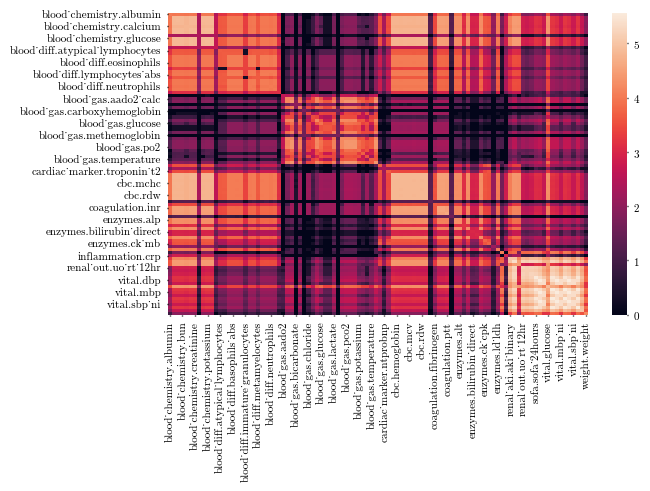

In [126]:

sns.heatmap(np.log10(cooc + 1))


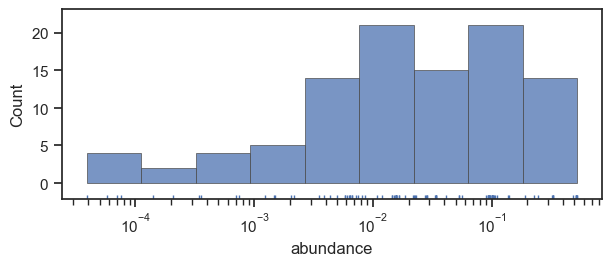

In [211]:
import matplotlib as mpl


p_mask = pd.DataFrame({'abundance': obs_mask.mean(axis=0)})


# sns.kdeplot(data=p_mask, x="abundance", log_scale=True)
# sns.rugplot(data=p_mask, x="abundance")
sns.set_theme(style="ticks")
# sns.kdeplot(data=p_mask, x="abundance", log_scale=True)
g = sns.rugplot(data=p_mask, x="abundance")
g.set_xscale('log')

sns.histplot(
    p_mask,
    x="abundance", 
    edgecolor=".3",
    linewidth=.5,
    log_scale=True,
)
g.get_figure().set_size_inches(fig_width_in, fig_height_in * 1.5)
g.get_figure().savefig(f"{RESULTS_DIR}/features_abundance.pdf")


# Model Configuration

In [7]:

def models(e):
    pmodels = {k: ProbStackedICNNImputer(observables_size=obs_mask.shape[1], state_size = 0, optax_optimiser_name='polyak_sgd',  
                                         positivity='abs', hidden_size_multiplier=2, depth=4, key=jrandom.PRNGKey(0))
               for k in PROP_MODELS}
    dmodels =  {k: ICNNObsDecoder(observables_size=obs_mask.shape[1], state_size = 0, optax_optimiser_name='polyak_sgd',
                                  positivity='abs', hidden_size_multiplier=3, depth=5, key=jrandom.PRNGKey(0)) 
                for k in DET_MODELS}
    return (pmodels | dmodels)[e]
    
def trainers(e):
    return {
        'ICNN_LN': ProbICNNImputerTrainer(loss='log_normal'),
        'ICNN_NLN': ProbICNNImputerTrainer(loss='log_normal', loss_feature_normalisation=True),
        'ICNN_KL': ProbICNNImputerTrainer(loss='kl_divergence'),
        'ICNN_NKL': ProbICNNImputerTrainer(loss='kl_divergence', loss_feature_normalisation=True),
        'ICNN_MSE': StandardICNNImputerTrainer(),
        'ICNN_NMSE': StandardICNNImputerTrainer(loss_feature_normalisation=True)
    }[e]

# model = models(EXP)
# trainer = trainers(EXP)

# Training

## ICNN Training

In [ ]:
# lr=1e-3
# steps=10000
# train_batch_size=256
# test_batch_size=1024
# # train_batch_size=1
# # test_batch_size=1
# eval_frequency = 10
# model_snapshot_frequency = 100

# optim = optax.novograd(lr)
# opt_state = optim.init(eqx.filter(model, eqx.is_inexact_array))
# data_train = (obs_val_train, obs_mask_train, art_mask_train)
# data_test = (obs_val_test, obs_mask_test, art_mask_test)

In [ ]:
# train_batches = trainer.dataloader(data_train, train_batch_size, key=jrandom.PRNGKey(0))
# test_batches = iter(trainer.dataloader(data_test, train_batch_size, key=jrandom.PRNGKey(0)))
# train_history = defaultdict(list)
# test_history = defaultdict(list)
# model_snapshots = {}

In [ ]:
# progress = tqdm(range(steps))

# for step, batch_train in zip(progress, train_batches):
#     start = time.time()
#     (train_loss, train_aux), model, opt_state = trainer.make_step(model, optim, opt_state, *batch_train)
#     r2_vec =  trainer.model_r_squared(model, *batch_train)
#     r2_vec_rank = trainer.model_r_squared_ranked_prob(model, *batch_train, k=5)
#     r2_vec = np.array(r2_vec)
#     train_nsteps = int(sum(train_aux.n_steps) / len(train_aux.n_steps))
#     train_history['R2'].append(r2_vec)
#     train_history['R2_rank5'].append(r2_vec_rank)
#     train_history['loss'].append(train_loss)
#     train_history['n_opt_steps'].append(train_nsteps)
    
#     end = time.time()
#     if (step % eval_frequency) == 0 or step == steps - 1:
#         batch_test = next(test_batches)
#         test_loss, _ = trainer.loss(model, *batch_test)
#         r2_vec_test = trainer.model_r_squared(model, *batch_test)
#         r2_vec_rank_test = trainer.model_r_squared_ranked_prob(model, *batch_test, k=10)
#         r2_vec_test = np.array(r2_vec_test)
#         test_history['loss'].append(test_loss)
#         test_history['R2'].append(r2_vec_test)
#         test_history['R2_rank10'].append(r2_vec_rank_test)

#     if (step % model_snapshot_frequency) == 0 or step == steps - 1:
#         model_snapshots[step] = model
#         append_params_to_zip(model, f'step{step:04d}.eqx', f'{EXP_DIR[EXP]}/params.zip')

#     progress.set_description(f"Trn-L: {train_loss:.3f}, Trn-R2: ({np.nanmax(r2_vec_rank):.2f}, {np.nanmin(r2_vec_rank):.2f}, {np.nanmean(r2_vec_rank):.2f}, {np.nanmedian(r2_vec_rank):.2f}),  Trn-N-steps: {train_nsteps}, " 
#                              f"Tst-L:  {test_loss:.3f}, Tst-R2:  ({np.nanmax(r2_vec_rank_test):.2f}, {np.nanmin(r2_vec_rank_test):.2f}, {np.nanmean(r2_vec_rank_test):.2f}, {np.nanmedian(r2_vec_rank_test):.2f}), "
#                              f"Computation time: {end - start:.2f}, ")
                            

In [ ]:
# zip_members(f'{EXP_DIR}/params.zip')

### Dump Training Statistics

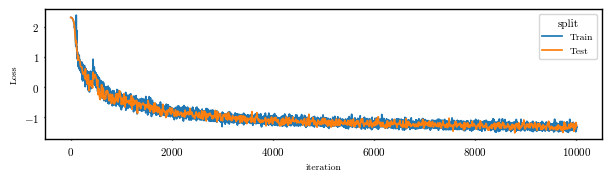

In [17]:
# FIRST TIME - BEGIN 

# train_stats = pd.DataFrame(train_history)
# test_stats = pd.DataFrame(test_history)

# train_stats['split'] = 'Train'
# train_stats['iteration'] = train_stats.index + 1
# test_stats['split'] = 'Test'
# test_stats['iteration'] = (test_stats.index * eval_frequency) + 1
# training_stats = pd.concat([train_stats, test_stats])
# training_stats_melted = pd.melt(training_stats, value_vars=['loss'], id_vars=['split', 'iteration'], value_name='Loss')
# training_stats_melted = training_stats_melted.astype({'Loss': float})

# training_stats.to_csv(f'{RESULTS_DIR}/{EXP}_training_stats.csv')  
# training_stats_melted.to_csv(f'{RESULTS_DIR}/{EXP}_training_stats_melted.csv')  

# FIRST TIME - END 


# LATER TIMES
training_stats = pd.read_csv(f'{RESULTS_DIR}/{EXP}_training_stats.csv', index_col=[0])  
training_stats_melted = pd.read_csv(f'{RESULTS_DIR}/{EXP}_training_stats_melted.csv', index_col=[0])  



g2 = sns.lineplot(data=training_stats_melted, x="iteration", y="Loss", hue="split")
g2.get_figure().set_size_inches(fig_width_in, fig_height_in)
g2.get_figure().savefig(f"{RESULTS_DIR}/{EXP}_training_stats.pdf")

## Sklearn Training

In [8]:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer, KNNImputer, SimpleImputer

sklearn_imputers =  {
    'zero_imputer': lambda: SimpleImputer(missing_values=np.nan, add_indicator=False, strategy="constant", fill_value=0),
    'mean_imputer': lambda: SimpleImputer(missing_values=np.nan, add_indicator=False, strategy="mean", fill_value=0),
    'knn_imputer': lambda: KNNImputer(missing_values=np.nan),
    'iter_imputer': lambda: IterativeImputer(
        missing_values=np.nan,
        add_indicator=False,
        random_state=0,
        n_nearest_features=5,
        max_iter=5,
        sample_posterior=True,
    )
}

# sklearn_trained_imputers = {k: v().fit(np.where(obs_mask_train, obs_val_train, np.nan)) for k, v in sklearn_imputers.items()} 

# Metrics / Results

In [9]:
prediction_mask = (1 - art_mask_test) * obs_mask_test
feature2index =  dict(zip(obs_val.columns, range(len(obs_val.columns))))
n_train = ((1 - art_mask_train) * obs_mask_train).sum(axis=0)
n_test = ((1 - art_mask_test) * obs_mask_test).sum(axis=0)
n_train_measured = obs_mask_train.sum(axis=0)
missingness = 1 - obs_mask.mean(axis=0)
validation_missingness = 1 - pd.DataFrame(art_mask_test, columns=obs_mask.columns).mean(axis=0)

In [199]:
n_test_censored = pd.Series(prediction_mask.sum(axis=0), index=obs_val.columns)
p_test_censored = n_test_censored / len(prediction_mask)
vars_n300 = n_test_censored[n_test_censored >= 300].index
vars_n300_r = n_test_censored[n_test_censored < 300].index
vars_n300, len(vars_n300)

(Index(['blood_chemistry.albumin', 'blood_chemistry.aniongap',
        'blood_chemistry.bicarbonate', 'blood_chemistry.bun',
        'blood_chemistry.calcium', 'blood_chemistry.chloride',
        'blood_chemistry.creatinine', 'blood_chemistry.glucose',
        'blood_chemistry.potassium', 'blood_chemistry.sodium',
        'blood_diff.basophils', 'blood_diff.basophils_abs',
        'blood_diff.eosinophils', 'blood_diff.eosinophils_abs',
        'blood_diff.lymphocytes', 'blood_diff.lymphocytes_abs',
        'blood_diff.monocytes', 'blood_diff.monocytes_abs',
        'blood_diff.neutrophils', 'blood_diff.neutrophils_abs',
        'blood_gas.aado2_calc', 'blood_gas.baseexcess', 'blood_gas.calcium',
        'blood_gas.fio2_chartevents', 'blood_gas.glucose', 'blood_gas.lactate',
        'blood_gas.pao2fio2ratio', 'blood_gas.pco2', 'blood_gas.ph',
        'blood_gas.po2', 'blood_gas.potassium', 'blood_gas.totalco2',
        'cardiac_marker.ck_mb', 'cardiac_marker.troponin_t2', 'cbc.hematocri

In [10]:
variable_map = {'blood_chemistry.albumin': 'Albumin',  'blood_chemistry.aniongap': 'Aniongap',  'blood_chemistry.bicarbonate': 'Bicarbonate',  'blood_chemistry.bun': 'Urea Nitrogen',  'blood_chemistry.calcium': 'Calcium',  'blood_chemistry.chloride': 'Chloride',  'blood_chemistry.creatinine': 'Creatinine',  'blood_chemistry.globulin': 'Globulin',  'blood_chemistry.glucose': 'Glucose',  'blood_chemistry.potassium': 'Potassium',  'blood_chemistry.sodium': 'Sodium',  'blood_chemistry.total_protein': 'Protein Total',  'blood_diff.atypical_lymphocytes': 'Atypical Lymphocytes',  'blood_diff.bands': 'Bands (%)',  'blood_diff.basophils': 'Basophils',  'blood_diff.basophils_abs': 'Abs Basophils',  'blood_diff.eosinophils': 'Eosinophils',  'blood_diff.eosinophils_abs': 'Abs Eosinophils',  'blood_diff.immature_granulocytes': 'Immature Granulocytes',  'blood_diff.lymphocytes': 'Lymphocytes',  'blood_diff.lymphocytes_abs': 'Abs Lymphocytes',  'blood_diff.metamyelocytes': 'Metamyelocytes',  'blood_diff.monocytes': 'Monocytes',  'blood_diff.monocytes_abs': 'Abs Monocytes',  'blood_diff.neutrophils': 'Neutrophils',  'blood_diff.neutrophils_abs': 'Abs Neutrophil',  'blood_diff.nrbc': 'NRBC',  'blood_gas.aado2': 'AaDO2',  'blood_gas.aado2_calc': 'AaDO2_calc',  'blood_gas.baseexcess': 'Base excess',  'blood_gas.bicarbonate': 'Bicarbonate',  'blood_gas.calcium': 'Calcium',  'blood_gas.carboxyhemoglobin': 'Carboxyhemoglobin',  'blood_gas.chloride': 'Chloride',  'blood_gas.fio2': 'FiO2',  'blood_gas.fio2_chartevents': 'FiO2_chartevents',  'blood_gas.glucose': 'Glucose',  'blood_gas.hematocrit': 'Hematocrit',  'blood_gas.hemoglobin': 'Hemoglobin',  'blood_gas.lactate': 'Lactate',  'blood_gas.methemoglobin': 'Methemoglobin',  'blood_gas.pao2fio2ratio': 'pO2/FiO2 ratio',  'blood_gas.pco2': 'pCO2',  'blood_gas.ph': 'pH',  'blood_gas.po2': 'pO2',  'blood_gas.potassium': 'Potassium',  'blood_gas.so2': 'sO2',  'blood_gas.sodium': 'Sodium',  'blood_gas.temperature': 'Temperature',  'blood_gas.totalco2': 'CO2 total',  'cardiac_marker.ck_mb': 'Creatinine Kinase, MB',  'cardiac_marker.ntprobnp': 'NT-proBNP',  'cardiac_marker.troponin_t2': 'Troponin T',  'cbc.hematocrit': 'Hematocrit',  'cbc.hemoglobin': 'Hemoglobin',  'cbc.mch': 'MCH',  'cbc.mchc': 'MCHC',  'cbc.mcv': 'MCV',  'cbc.platelet': 'Platelet',  'cbc.rbc': 'RBC',  'cbc.rdw': 'RDW',  'cbc.wbc': 'WBC',  'coagulation.d_dimer': 'D-Dimer',  'coagulation.fibrinogen': 'Fibrinogen',  'coagulation.inr': 'INR',  'coagulation.pt': 'PT',  'coagulation.ptt': 'PTT',  'coagulation.thrombin': 'Thrombin',  'enzymes.alp': 'ALP',  'enzymes.alt': 'ALT',  'enzymes.amylase': 'Amylase',  'enzymes.ast': 'AST',  'enzymes.bilirubin_direct': 'Bilirubin direct',  'enzymes.bilirubin_indirect': 'Bilirubin indirect',  'enzymes.bilirubin_total': 'Bilirubin total',  'enzymes.ck_cpk': 'CK-CPK',  'enzymes.ck_mb':'CK-MB',  'enzymes.ggt': 'GGT',  'enzymes.ld_ldh': 'ld_ldh',  'icp.icp': 'Intra-cranial Press.',  'inflammation.crp': 'CRP',  'renal_aki.aki_binary': 'AKI (binary)',  'renal_aki.aki_stage_smoothed': 'AKI',  'renal_creat.creat': 'Creatinine',  'renal_out.uo_rt_12hr': 'Urine out 12h',  'renal_out.uo_rt_24hr': 'Urine out 24h',  'renal_out.uo_rt_6hr': 'Urine out 6h',  'sofa.sofa_24hours': 'SOFA',  'vital.dbp': 'Diastolic BP',  'vital.dbp_ni': 'NI-Diastolic BP',  'vital.glucose': 'Glucose',  'vital.heart_rate': 'Heart Rate',  'vital.mbp':  'Mean BP',  'vital.mbp_ni': 'NI Mean BP',  'vital.resp_rate': 'Respiratory Rate',  'vital.sbp': 'Systolic BP',  'vital.sbp_ni':  'NI-Systolic BP',  'vital.spo2': 'SpO2',  'vital.temperature': 'Temperature',  'weight.weight': 'Weight'}

## Metrics Evolution with ICNN Training

In [21]:
# FIRST TIME - BEGIN 

# dataframes = []
# for step, model_snap in tqdm(model_snapshots.items()):
#     with jax.default_device(jax.devices("cpu")[0]):
#         obs_test = jnp.where(art_mask_test, obs_val_test, 0.)
#         (X_test_imp, X_test_std), _ = eqx.filter_vmap(model_snap.prob_partial_input_optimise)(obs_test, art_mask_test)
    
#     sigma_threshold = [4.0, 3.0, 2.5, 2.0, 1.5, 1.0, 0.5, 0.3, 0.2, 0.1, 0.05, 0.01]
#     r2_vec_thresholded = [eqx.filter_vmap(ProbICNNImputerTrainer.r_squared_thresholded_prob)(obs_val_test.T, X_test_imp.T, prediction_mask.T, X_test_std.T,  t)
#                           for t in sigma_threshold]
    
#     r2_test_results = pd.DataFrame(np.vstack(r2_vec_thresholded), columns=obs_val.columns)
#     r2_test_results['sigma_threshold'] = sigma_threshold
#     r2_test_results['step'] = step
#     dataframes.append(r2_test_results)

# r2_iters_test_results = pd.concat(dataframes)
# r2_iters_test_results = pd.melt(r2_iters_test_results, value_vars=list(obs_val.columns), id_vars=['sigma_threshold', 'step'], value_name='R2')

# r2_iters_test_results.to_csv(f'{RESULTS_DIR}/{EXP}_r2_iters_test_results.csv')
# FIRST TIME - END 
# r2_iters_test_results = pd.read_csv(f'{RESULTS_DIR}/{EXP}_r2_iters_test_results.csv', index_col=[0])

In [22]:
# r2_iters_test_results

## Metrics of the Last ICNN Snapshot

### Inference with Last ICNN Snapshot (one-time)

In [17]:
# FIRST TIME - BEGIN 
# model = model.load_params_from_archive(f'{EXP_DIR[EXP]}/params.zip', 'step9999.eqx')
# with jax.default_device(jax.devices("cpu")[0]):
#     obs_test = jnp.where(art_mask_test, obs_val_test, 0.)
#     (X_test_imp, X_test_std), _ = eqx.filter_vmap(model.prob_partial_input_optimise)(obs_test, art_mask_test)

# X_test_imp_df = pd.DataFrame(X_test_imp, columns=obs_val.columns)
# X_test_std_df = pd.DataFrame(X_test_std, columns=obs_val.columns)

# X_test_imp_df.to_csv(f'{RESULTS_DIR}/{EXP}_pred_X_test_imp.csv')
# X_test_std_df.to_csv(f'{RESULTS_DIR}/{EXP}_pred_X_test_std.csv')
# FIRST TIME - END 

### Load ICNN Inference from Disk (one-time)

In [223]:
all_models_X_test_imp_df = {}
prob_models_X_test_std_df = {}
prob_models_X_var_stats_df = []
all_models_X_test_se = []
all_models_features_stats_df = []
all_models_stats_df = []

for model_name in list(EXP_DIR.keys()) + list(sklearn_imputers.keys()):
    x_file = f'{RESULTS_DIR}/{model_name}_pred_X_test_imp.csv'
    s_file = f'{RESULTS_DIR}/{model_name}_pred_X_test_std.csv'
    if os.path.isfile(x_file):
        X_test_imp_ = pd.read_csv(x_file, index_col=[0])
        all_models_X_test_imp_df[model_name] = X_test_imp_

        # Squared-Errors (per instance)
        X_test_se_ = (X_test_imp_ - np.array(obs_val_test))**2
        X_test_se_ = X_test_se_.where(prediction_mask.astype(bool), other=np.nan)
        X_test_se_ = pd.melt(X_test_se_, value_vars=list(obs_val.columns), value_name='SE')
        X_test_se_ = X_test_se_[X_test_se_.SE.notnull()]
        X_test_se_['Imputer'] = model_name
        all_models_X_test_se.append(X_test_se_)


    if os.path.isfile(s_file):
        X_test_std_ = pd.read_csv(s_file, index_col=[0])
        prob_models_X_test_std_df[model_name] = X_test_std_
        
        X_test_var_ = np.where(prediction_mask.astype(bool), X_test_std_ ** 2, np.nan)
        SE_ = (all_models_X_test_imp_df[model_name] - np.array(obs_val_test)) ** 2
        SE_ = np.where(prediction_mask.astype(bool), SE_, np.nan)
        se_data_ = defaultdict(list)
        for i in range(SE_.shape[1]):
            se_data_['SE'].extend(np.array(SE_[:, i][prediction_mask[:, i].astype(bool)]).tolist())
            se_data_[r'$\hat{\sigma}^2$'].extend(np.array(X_test_var_[:, i][prediction_mask[:, i].astype(bool)]).tolist())
            se_data_['Feature'].extend([obs_val.columns[i]] * int(prediction_mask[:, i].sum()))
        se_df_ = pd.DataFrame(se_data_)
        se_df_['Imputer'] = model_name
        prob_models_X_var_stats_df.append(se_df_)

    if model_name not in all_models_X_test_imp_df:
        continue

    # R2/MSE (per feature)
    X_test_imp_ = jnp.array(all_models_X_test_imp_df[model_name])
    features_r2_ = eqx.filter_vmap(ProbICNNImputerTrainer.r_squared)(obs_val_test.T, X_test_imp_.T, prediction_mask.T)
    se_ = (np.array(all_models_X_test_imp_df[model_name]) - np.array(obs_val_test)) ** 2
    mse_ = np.nanmean(se_, axis=0, where=prediction_mask.astype(bool))
    features_stats_df_ = pd.DataFrame({r'$R^2$': np.array(features_r2_), 
                                       'MSE': mse_,
                                       'Feature': all_models_X_test_imp_df[model_name].columns,
                                       'Imputer': [model_name] * len(mse_)})

    # r_spearman(SE, sigma2) (per feature)
    if model_name in prob_models_X_test_std_df:
        X_test_var_ = np.where(prediction_mask.astype(bool), prob_models_X_test_std_df[model_name] ** 2, np.nan)
        features_stats_df_[r'$r(SE, \hat{\sigma}^2)$'] = [spearmanr(se_i[mi], sigma2_i[mi]).statistic
                                                 for se_i, sigma2_i, mi in zip(se_.T, X_test_var_.T, prediction_mask.astype(bool).T)]

    all_models_features_stats_df.append(features_stats_df_)

    # R2/MSE (per model)
    model_stats_df_ = pd.DataFrame({'Imputer': [model_name],
                                    'MSE': [np.nanmean(se_, where=prediction_mask.astype(bool))],
                                    r'$R^2$': [ProbICNNImputerTrainer.r_squared(obs_val_test, X_test_imp_, prediction_mask).item()]})

    # corr(SE, sigma2) (per model)
    if model_name in prob_models_X_test_std_df:
        X_test_var_ = np.where(prediction_mask.astype(bool), prob_models_X_test_std_df[model_name] ** 2, np.nan).flatten()
        m_ = prediction_mask.astype(bool).flatten()
        model_stats_df_[r'$r_\text{Pearson}(SE, \hat{\sigma}^2)$'] = [pearsonr(se_.flatten()[m_], X_test_var_[m_]).statistic]
        model_stats_df_[r'$r_\text{Spearman}(SE, \hat{\sigma}^2)$'] = [spearmanr(se_.flatten()[m_], X_test_var_[m_]).statistic]
    all_models_stats_df.append(model_stats_df_)
    
all_models_X_test_se = pd.concat(all_models_X_test_se)
prob_models_X_var_stats_df = pd.concat(prob_models_X_var_stats_df)
all_models_features_stats_df = pd.concat(all_models_features_stats_df)
all_models_stats_df = pd.concat(all_models_stats_df)

In [184]:
all_models_features_stats_df

,$R^2$,MSE,Feature,Imputer,"$r(SE, \hat{\sigma}^2)$","$r(SE, \hat{\sigma}^2)$ bin",$R^2$ bin
0,-18.791556,0.338596,blood_chemistry.albumin,ICNN_LN,-0.095714,"$r \in [-0.1, 0.1]$",$R^2 < -9$
1,-0.633369,0.032923,blood_chemistry.aniongap,ICNN_LN,0.151935,"$r \in [0.1, 0.3]$","$R^2 \in (-1, -0.1]$"
2,-0.511465,0.020465,blood_chemistry.bicarbonate,ICNN_LN,0.113759,"$r \in [0.1, 0.3]$","$R^2 \in (-1, -0.1]$"
3,-0.219971,0.051564,blood_chemistry.bun,ICNN_LN,0.058487,"$r \in [-0.1, 0.1]$","$R^2 \in (-1, -0.1]$"
4,-2.204620,0.012969,blood_chemistry.calcium,ICNN_LN,0.103926,"$r \in [0.1, 0.3]$","$R^2 \in (-9, -1]$"
...,...,...,...,...,...,...,...
95,0.452593,0.007647,vital.sbp,iter_imputer,NaN,NA,$R^2 > 0.25$
96,0.820376,0.002518,vital.sbp_ni,iter_imputer,NaN,NA,$R^2 > 0.25$
97,-0.972564,0.001281,vital.spo2,iter_imputer,NaN,NA,"$R^2 \in (-1, -0.1]$"
98,-0.918125,0.000421,vital.temperature,iter_imputer,NaN,NA,"$R^2 \in (-1, -0.1]$"


In [205]:
p_abundance = obs_mask.mean(axis=0)
for name, model_df in all_models_features_stats_df.groupby('Imputer'):
    df = model_df[model_df.Feature.isin(vars_n300)]
    stat = spearmanr(df[r'$R^2$'], df.Feature.map(p_abundance)).statistic
    loc = all_models_stats_df.Imputer == name
    all_models_stats_df.loc[loc, r'$r_\text{Spearman}(R^2, \text{abundance})$'] = stat
    

In [206]:
all_models_stats_df

,Imputer,MSE,$R^2$,"$r_\text{Pearson}(SE, \hat{\sigma}^2)$","$r_\text{Spearman}(SE, \hat{\sigma}^2)$","$r_\text{Spearman}(R^2, \text{abundance})$"
0,ICNN_LN,0.110200,0.08888369498337212,0.486482,0.528621,0.622578
0,ICNN_NLN,0.092614,0.23428153705997257,0.359050,0.523306,0.443354
0,ICNN_KL,0.085771,0.2908603178472814,0.011902,0.182318,0.380291
0,ICNN_NKL,0.081217,0.3285100138043464,0.027086,0.196668,0.253702
0,zero_imputer,0.188635,-0.5596053103498799,NaN,NaN,-0.420739
0,mean_imputer,0.100373,0.17012786836232063,NaN,NaN,0.413396
0,knn_imputer,0.142751,-0.1802500119395256,NaN,NaN,-0.142324
0,iter_imputer,0.086248,0.28691167730594647,NaN,NaN,0.077502


In [151]:
all_models_features_stats_df

,$R^2$,MSE,Feature,Imputer,"$r(SE, \hat{\sigma}^2)$"
0,-18.791556,0.338596,blood_chemistry.albumin,ICNN_LN,-0.095714
1,-0.633369,0.032923,blood_chemistry.aniongap,ICNN_LN,0.151935
2,-0.511465,0.020465,blood_chemistry.bicarbonate,ICNN_LN,0.113759
3,-0.219971,0.051564,blood_chemistry.bun,ICNN_LN,0.058487
4,-2.204620,0.012969,blood_chemistry.calcium,ICNN_LN,0.103926
...,...,...,...,...,...
95,0.452593,0.007647,vital.sbp,iter_imputer,NaN
96,0.820376,0.002518,vital.sbp_ni,iter_imputer,NaN
97,-0.972564,0.001281,vital.spo2,iter_imputer,NaN
98,-0.918125,0.000421,vital.temperature,iter_imputer,NaN


In [152]:
r_classes = [r'$r > 0.3$', r'$r \in [0.1, 0.3]$', r'$r \in [-0.1, 0.1]$', r'$r \leq -0.1$']
R_classes = [r'$R^2 > 0.25$', r'$R^2 \in (0.1, 0.25]$', r'$R^2 \in [-0.1, 0.1]$', r'$R^2 \in (-1, -0.1]$',  r'$R^2 \in (-9, -1]$', r'$R^2 < -9$']
def classify_r(r):
    if r > 0.3:
        return r_classes[0]
    elif r > 0.1:
        return r_classes[1]
    elif r >= -0.1:
        return r_classes[2]
    elif r < -0.1:
        return r_classes[3]
    else:
        return 'NA'

def classify_R(R):
    if R > 0.25:
        return R_classes[0]
    elif R > 0.1:
        return R_classes[1]
    elif R >= -0.1:
        return R_classes[2]
    elif R >= -1:
        return R_classes[3] 
    elif R >= -9:
        return R_classes[4]
    elif R < -9:
        return R_classes[5]
    else:
        return 'NA'

all_models_features_stats_df[r'$r(SE, \hat{\sigma}^2)$ bin'] = all_models_features_stats_df[r'$r(SE, \hat{\sigma}^2)$'].map(classify_r)
all_models_features_stats_df[r'$R^2$ bin'] = all_models_features_stats_df[r'$R^2$'].map(classify_R)


In [154]:
prob_models_features_stats_df.sort_values(r'$r(SE, \hat{\sigma}^2)$')

,$R^2$,MSE,Feature,Imputer,"$r(SE, \hat{\sigma}^2)$","$r(SE, \hat{\sigma}^2)$ bin",$R^2$ bin
29,-0.028819,1.083599,blood_gas.baseexcess,ICNN_LN,-0.106153,$r \leq -0.1$,"$r \in [-0.1, 0.1]$"
31,-17.713607,0.036938,blood_gas.calcium,ICNN_LN,-0.097828,"$r \in [-0.1, 0.1]$",$r \leq -0.1$
0,-18.791556,0.338596,blood_chemistry.albumin,ICNN_LN,-0.095714,"$r \in [-0.1, 0.1]$",$r \leq -0.1$
81,-0.042202,0.089494,renal_aki.aki_binary,ICNN_NLN,-0.076514,"$r \in [-0.1, 0.1]$","$r \in [-0.1, 0.1]$"
36,-9.103304,0.218998,blood_gas.glucose,ICNN_LN,-0.073565,"$r \in [-0.1, 0.1]$",$r \leq -0.1$
...,...,...,...,...,...,...,...
90,-121.994530,0.005050,vital.glucose,ICNN_LN,0.378032,$r > 0.3$,$r \leq -0.1$
82,0.295106,0.100273,renal_aki.aki_stage_smoothed,ICNN_LN,0.387777,$r > 0.3$,"$r \in [0.1, 0.3]$"
39,-1.665652,0.067936,blood_gas.lactate,ICNN_LN,0.393366,$r > 0.3$,$r \leq -0.1$
75,-0.923759,0.015600,enzymes.ck_cpk,ICNN_NLN,0.396143,$r > 0.3$,$r \leq -0.1$


In [155]:
prob_models_features_stats_df = all_models_features_stats_df[all_models_features_stats_df[r'$r(SE, \hat{\sigma}^2)$'].notnull()]
prob_models_features_stats_df = prob_models_features_stats_df[prob_models_features_stats_df.Feature.isin(vars_n300)]
r_bins = prob_models_features_stats_df.groupby(['Imputer', r'$r(SE, \hat{\sigma}^2)$ bin'])['Feature'].count().reset_index()
r_bins.columns = ['Imputer', r'$r(SE, \hat{\sigma}^2)$ bin', 'Count']
r_bins = r_bins.pivot_table(index="Imputer", values='Count', columns=r'$r(SE, \hat{\sigma}^2)$ bin')

# r_bins = r_bins[r_classes]
r_bins

"$r(SE, \hat{\sigma}^2)$ bin",$r > 0.3$,"$r \in [-0.1, 0.1]$","$r \in [0.1, 0.3]$",$r \leq -0.1$
Imputer,,,,
ICNN_KL,1.0,51.0,19.0,2.0
ICNN_LN,4.0,43.0,25.0,1.0
ICNN_NKL,1.0,57.0,15.0,NaN
ICNN_NLN,3.0,53.0,17.0,NaN


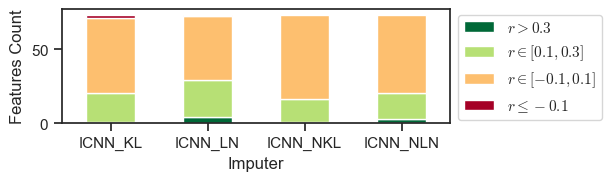

In [156]:
ax = r_bins.plot(y=r_classes, kind="bar", rot=0, stacked=True, colormap='RdYlGn_r', ylabel='Features Count')
_ = ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left')
ax.get_figure().set_size_inches(fig_width_in, fig_height_in)
ax.get_figure().savefig(f"{RESULTS_DIR}/{EXP}_r2_bins.pdf")

In [216]:
ablation_models = [m for m in all_models_stats_df.Imputer.unique() if m.startswith('ICNN')]

table_ablation0 = all_models_stats_df.set_index('Imputer').loc[ablation_models,  ['MSE', r'$R^2$', r'$r_\text{Spearman}(SE, \hat{\sigma}^2)$'] ].transpose()
table_ablation0.columns =  list(map(lambda c: f'\\texttt{{{c}}}', table_ablation0.columns))
table_ablation0.columns = list(map(lambda c: c.replace("_", "\\_"), table_ablation0.columns))
table_ablation0.columns.name = 'Imputer'
table_ablation0 = table_ablation0.sort_values(r'$R^2$', axis=1)
table_ablation0

Imputer,\texttt{ICNN\_LN},\texttt{ICNN\_NLN},\texttt{ICNN\_KL},\texttt{ICNN\_NKL}
MSE,0.1102,0.092614,0.085771,0.081217
$R^2$,0.08888369498337212,0.23428153705997257,0.2908603178472814,0.3285100138043464
"$r_\text{Spearman}(SE, \hat{\sigma}^2)$",0.528621,0.523306,0.182318,0.196668


In [221]:
table_stl_ablation0 = (table_ablation0.style
              .background_gradient(cmap='RdYlGn', axis=1, low=-0, high=0.5,  vmin=-0.6, vmax=0.3, subset= pd.IndexSlice[[r'$R^2$'], :])
              .background_gradient(cmap='RdYlGn_r', axis=1,  low=0.12, high=0.28,  vmin=0.09, vmax=0.19, subset= pd.IndexSlice[['MSE'], :])
              # .apply_index(lambda x: ["background-color: #E5E4E2;"] * len(x))
              .format(precision=3))
table_stl_ablation0

Imputer,\texttt{ICNN\_LN},\texttt{ICNN\_NLN},\texttt{ICNN\_KL},\texttt{ICNN\_NKL}
MSE,0.110,0.093,0.086,0.081
$R^2$,0.08888369498337212,0.23428153705997257,0.2908603178472814,0.3285100138043464
"$r_\text{Spearman}(SE, \hat{\sigma}^2)$",0.529,0.523,0.182,0.197


In [222]:
table_stl_ablation0 = (table_stl_ablation0.to_latex(caption="$R^2$-scores and \gls*{mse} across all features on the test split.",
                       position_float="centering",
                       convert_css=True,
                       hrules=True,)
              .replace('\\toprule', '\\hline').replace('\\midrule', '\\hline').replace('\\bottomrule','\\hline'))
print(table0_str)

Imputer                                        object
MSE                                           float64
$R^2$                                          object
$r_\text{Pearson}(SE, \hat{\sigma}^2)$        float64
$r_\text{Spearman}(SE, \hat{\sigma}^2)$       float64
$r_\text{Spearman}(R^2, \text{abundance})$    float64
dtype: object

## Metrics of Sklearn Models

In [157]:
# FIRST TIME - BEGIN 
# sklearn_imputed_X = {k: v.transform(np.where(art_mask_test, obs_val_test, np.nan)) for k, v in sklearn_trained_imputers.items()} 
# for sklearn_name, imputed_X_ in sklearn_imputed_X.items():
#     X_test_imp_df = pd.DataFrame(imputed_X_, columns=obs_val.columns)    
#     X_test_imp_df.to_csv(f'{RESULTS_DIR}/{sklearn_name}_pred_X_test_imp.csv')
# FIRST TIME - END 

In [158]:
all_models_X_test_se

,variable,SE,Imputer
1065,blood_chemistry.albumin,0.698059,ICNN_LN
1230,blood_chemistry.albumin,0.687116,ICNN_LN
1484,blood_chemistry.albumin,0.000719,ICNN_LN
1675,blood_chemistry.albumin,0.000834,ICNN_LN
1847,blood_chemistry.albumin,0.201607,ICNN_LN
...,...,...,...
20815337,weight.weight,0.015889,iter_imputer
20815638,weight.weight,0.091407,iter_imputer
20815715,weight.weight,0.088486,iter_imputer
20815748,weight.weight,0.004486,iter_imputer


In [159]:
all_models_X_test_se['group'] = all_models_X_test_se.variable.str.split('.').map(lambda x: x[0])
all_models_X_test_se['Feature'] = all_models_X_test_se.variable.map(variable_map)

In [160]:
groups = all_models_X_test_se['group'].unique().tolist()
groups

['blood_chemistry',
 'blood_diff',
 'blood_gas',
 'cardiac_marker',
 'cbc',
 'coagulation',
 'enzymes',
 'icp',
 'inflammation',
 'renal_aki',
 'renal_creat',
 'renal_out',
 'sofa',
 'vital',
 'weight']

/home/asem/GP/env/icenode-dev/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


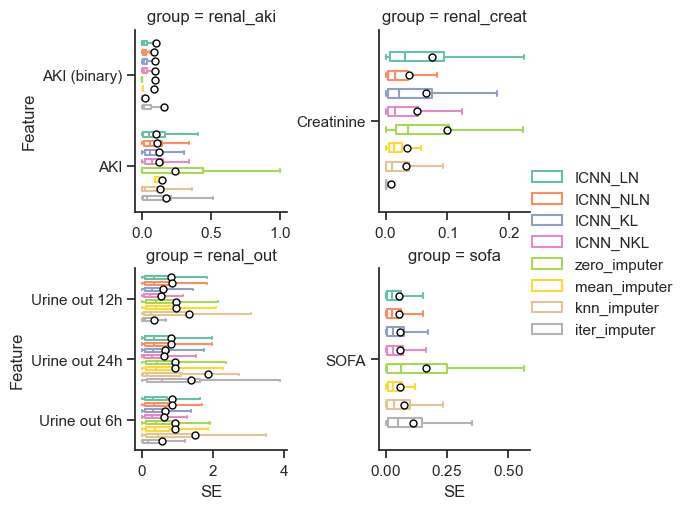

In [161]:
# enzymes (except Amylase, Bilirubin indirect, CK-CPK)
# renal_creat
# renal_aki
# renal_out
# sofa

X_test_se_df_selection = all_models_X_test_se[all_models_X_test_se.group.isin(['renal_out', 'renal_creat', 'renal_aki', 'sofa'])]

grid = sns.FacetGrid(data=X_test_se_df_selection, col="group", sharex=False, sharey=False, col_wrap=2,  )

grid.map_dataframe(sns.boxplot, x="SE", y="Feature", hue="Imputer", dodge=True,  palette="Set2",#hue="Imputer",
                   showmeans=True, meanprops={'marker':'o','markerfacecolor':'white','markeredgecolor':'black','markersize':'5'},
                    # line_kws=dict(linewidth=1.5, color="#cde"),
                    showfliers=False,
                    fill=False,
                     gap=0.5)

# grid.map_dataframe(sns.boxenplot, x="SE", y="Feature", hue="Imputer", dodge=True,  palette="Set2",#hue="Imputer",
#                     # line_kws=dict(linewidth=1.5, color="#cde"),
#                     showfliers=False,
#                     fill=False,
#                      gap=0.5)

grid.add_legend()
grid.figure.set_size_inches(fig_width_in * 1.2, fig_height_in * 3)
grid.savefig(f"{RESULTS_DIR}/X_test_se_df_selection.pdf")

In [162]:
all_models_features_stats_df

,$R^2$,MSE,Feature,Imputer,"$r(SE, \hat{\sigma}^2)$","$r(SE, \hat{\sigma}^2)$ bin",$R^2$ bin
0,-18.791556,0.338596,blood_chemistry.albumin,ICNN_LN,-0.095714,"$r \in [-0.1, 0.1]$",$R^2 < -9$
1,-0.633369,0.032923,blood_chemistry.aniongap,ICNN_LN,0.151935,"$r \in [0.1, 0.3]$","$R^2 \in (-1, -0.1]$"
2,-0.511465,0.020465,blood_chemistry.bicarbonate,ICNN_LN,0.113759,"$r \in [0.1, 0.3]$","$R^2 \in (-1, -0.1]$"
3,-0.219971,0.051564,blood_chemistry.bun,ICNN_LN,0.058487,"$r \in [-0.1, 0.1]$","$R^2 \in (-1, -0.1]$"
4,-2.204620,0.012969,blood_chemistry.calcium,ICNN_LN,0.103926,"$r \in [0.1, 0.3]$","$R^2 \in (-9, -1]$"
...,...,...,...,...,...,...,...
95,0.452593,0.007647,vital.sbp,iter_imputer,NaN,NA,$R^2 > 0.25$
96,0.820376,0.002518,vital.sbp_ni,iter_imputer,NaN,NA,$R^2 > 0.25$
97,-0.972564,0.001281,vital.spo2,iter_imputer,NaN,NA,"$R^2 \in (-1, -0.1]$"
98,-0.918125,0.000421,vital.temperature,iter_imputer,NaN,NA,"$R^2 \in (-1, -0.1]$"


In [163]:
table0 = all_models_stats_df.set_index('Imputer').transpose()
table0.columns =  list(map(lambda c: f'\\texttt{{{c}}}', table0.columns))
table0.columns = list(map(lambda c: c.replace("_", "\\_"), table0.columns))
table0.columns.name = 'Imputer'
table0 = table0.sort_values(r'$R^2$', axis=1)
table0

Imputer,\texttt{zero\_imputer},\texttt{knn\_imputer},\texttt{ICNN\_LN},\texttt{mean\_imputer},\texttt{ICNN\_NLN},\texttt{iter\_imputer},\texttt{ICNN\_KL},\texttt{ICNN\_NKL}
MSE,0.188635,0.142751,0.1102,0.100373,0.092614,0.086248,0.085771,0.081217
$R^2$,-0.5596053103498799,-0.1802500119395256,0.08888369498337212,0.17012786836232063,0.23428153705997257,0.28691167730594647,0.2908603178472814,0.3285100138043464
"$r_\text{Pearson}(SE, \hat{\sigma}^2)$",NaN,NaN,0.486482,NaN,0.35905,NaN,0.011902,0.027086
"$r_\text{Spearman}(SE, \hat{\sigma}^2)$",NaN,NaN,0.528621,NaN,0.523306,NaN,0.182318,0.196668


In [164]:
table0_stl = (table0.style
              .background_gradient(cmap='RdYlGn', axis=1, low=-0, high=0.5,  vmin=-0.6, vmax=0.3, subset= pd.IndexSlice[[r'$R^2$'], :])
              .background_gradient(cmap='RdYlGn_r', axis=1,  low=0.12, high=0.28,  vmin=0.09, vmax=0.19, subset= pd.IndexSlice[['MSE'], :])
              # .apply_index(lambda x: ["background-color: #E5E4E2;"] * len(x))
              .format(precision=3))
table0_stl

Imputer,\texttt{zero\_imputer},\texttt{knn\_imputer},\texttt{ICNN\_LN},\texttt{mean\_imputer},\texttt{ICNN\_NLN},\texttt{iter\_imputer},\texttt{ICNN\_KL},\texttt{ICNN\_NKL}
MSE,0.189,0.143,0.110,0.100,0.093,0.086,0.086,0.081
$R^2$,-0.5596053103498799,-0.1802500119395256,0.08888369498337212,0.17012786836232063,0.23428153705997257,0.28691167730594647,0.2908603178472814,0.3285100138043464
"$r_\text{Pearson}(SE, \hat{\sigma}^2)$",nan,nan,0.486,nan,0.359,nan,0.012,0.027
"$r_\text{Spearman}(SE, \hat{\sigma}^2)$",nan,nan,0.529,nan,0.523,nan,0.182,0.197


In [165]:
table0_str = (table0_stl.to_latex(caption="$R^2$-scores and \gls*{mse} across all features on the test split.",
                       position_float="centering",
                       convert_css=True,
                       hrules=True,)
              .replace('\\toprule', '\\hline').replace('\\midrule', '\\hline').replace('\\bottomrule','\\hline'))
print(table0_str)

\begin{table}
\centering
\caption{$R^2$-scores and \gls*{mse} across all features on the test split.}
\begin{tabular}{lllllllll}
\hline
Imputer & \texttt{zero\_imputer} & \texttt{knn\_imputer} & \texttt{ICNN\_LN} & \texttt{mean\_imputer} & \texttt{ICNN\_NLN} & \texttt{iter\_imputer} & \texttt{ICNN\_KL} & \texttt{ICNN\_NKL} \\
\hline
MSE & {\cellcolor[HTML]{F57245}} \color[HTML]{F1F1F1} 0.189 & {\cellcolor[HTML]{F1F9AC}} \color[HTML]{000000} 0.143 & {\cellcolor[HTML]{78C565}} \color[HTML]{000000} 0.110 & {\cellcolor[HTML]{45AD5B}} \color[HTML]{F1F1F1} 0.100 & {\cellcolor[HTML]{1B9950}} \color[HTML]{F1F1F1} 0.093 & {\cellcolor[HTML]{0F8446}} \color[HTML]{F1F1F1} 0.086 & {\cellcolor[HTML]{0E8245}} \color[HTML]{F1F1F1} 0.086 & {\cellcolor[HTML]{05713C}} \color[HTML]{F1F1F1} 0.081 \\
$R^2$ & {\cellcolor[HTML]{B30D26}} \color[HTML]{F1F1F1} -0.5596053103498799 & {\cellcolor[HTML]{FDB365}} \color[HTML]{000000} -0.1802500119395256 & {\cellcolor[HTML]{FBFDBA}} \color[HTML]{000000} 0.088883694983

In [166]:
prob_corr_df = all_models_stats_df.loc[all_models_stats_df.Imputer.isin(['ICNN_LN', 'ICNN_NLN', 'ICNN_NKL', 'ICNN_KL']), ['Imputer', r'$r_\text{Pearson}(SE, \hat{\sigma}^2)$', r'$r_\text{Spearman}(SE, \hat{\sigma}^2)$']]

In [167]:
table1_stl = (prob_corr_df.style.format(precision=3).hide())
table1_str = table1_stl.to_latex(caption=r"Correlation between predicted Gaussian variance $\sigma^2$ by \texttt{ICNN\_LN} and the prediction \gls*{se}.",
                       position_float="centering",
                       convert_css=True,
                       hrules=True,)
print(table1_str)

\begin{table}
\centering
\caption{Correlation between predicted Gaussian variance $\sigma^2$ by \texttt{ICNN\_LN} and the prediction \gls*{se}.}
\begin{tabular}{lrr}
\toprule
Imputer & $r_\text{Pearson}(SE, \hat{\sigma}^2)$ & $r_\text{Spearman}(SE, \hat{\sigma}^2)$ \\
\midrule
ICNN_LN & 0.486 & 0.529 \\
ICNN_NLN & 0.359 & 0.523 \\
ICNN_KL & 0.012 & 0.182 \\
ICNN_NKL & 0.027 & 0.197 \\
\bottomrule
\end{tabular}
\end{table}



In [168]:
prob_models_features_stats_df = all_models_features_stats_df[all_models_features_stats_df[r'$r(SE, \hat{\sigma}^2)$'].notnull()]
prob_models_features_stats_df = prob_models_features_stats_df[prob_models_features_stats_df.Feature.isin(vars_n300)]
r_bins = prob_models_features_stats_df.groupby(['Imputer', r'$r(SE, \hat{\sigma}^2)$ bin'])['Feature'].count().reset_index()
r_bins.columns = ['Imputer', r'$r(SE, \hat{\sigma}^2)$ bin', 'Count']
r_bins = r_bins.pivot_table(index="Imputer", values='Count', columns=r'$r(SE, \hat{\sigma}^2)$ bin')

# r_bins = r_bins[r_classes]
r_bins


"$r(SE, \hat{\sigma}^2)$ bin",$r > 0.3$,"$r \in [-0.1, 0.1]$","$r \in [0.1, 0.3]$",$r \leq -0.1$
Imputer,,,,
ICNN_KL,1.0,51.0,19.0,2.0
ICNN_LN,4.0,43.0,25.0,1.0
ICNN_NKL,1.0,57.0,15.0,NaN
ICNN_NLN,3.0,53.0,17.0,NaN


In [169]:
all_models_features_stats_df


,$R^2$,MSE,Feature,Imputer,"$r(SE, \hat{\sigma}^2)$","$r(SE, \hat{\sigma}^2)$ bin",$R^2$ bin
0,-18.791556,0.338596,blood_chemistry.albumin,ICNN_LN,-0.095714,"$r \in [-0.1, 0.1]$",$R^2 < -9$
1,-0.633369,0.032923,blood_chemistry.aniongap,ICNN_LN,0.151935,"$r \in [0.1, 0.3]$","$R^2 \in (-1, -0.1]$"
2,-0.511465,0.020465,blood_chemistry.bicarbonate,ICNN_LN,0.113759,"$r \in [0.1, 0.3]$","$R^2 \in (-1, -0.1]$"
3,-0.219971,0.051564,blood_chemistry.bun,ICNN_LN,0.058487,"$r \in [-0.1, 0.1]$","$R^2 \in (-1, -0.1]$"
4,-2.204620,0.012969,blood_chemistry.calcium,ICNN_LN,0.103926,"$r \in [0.1, 0.3]$","$R^2 \in (-9, -1]$"
...,...,...,...,...,...,...,...
95,0.452593,0.007647,vital.sbp,iter_imputer,NaN,NA,$R^2 > 0.25$
96,0.820376,0.002518,vital.sbp_ni,iter_imputer,NaN,NA,$R^2 > 0.25$
97,-0.972564,0.001281,vital.spo2,iter_imputer,NaN,NA,"$R^2 \in (-1, -0.1]$"
98,-0.918125,0.000421,vital.temperature,iter_imputer,NaN,NA,"$R^2 \in (-1, -0.1]$"


In [175]:
all_models_filtered_features_stats_df = all_models_features_stats_df[all_models_features_stats_df.Feature.isin(vars_n300)]
R_bins = all_models_filtered_features_stats_df.groupby(['Imputer', r'$R^2$ bin'])['Feature'].count().reset_index()
R_bins.columns = ['Imputer', r'$R^2$ bin', 'Count']
R_bins = R_bins.pivot_table(index="Imputer", values='Count', columns=r'$R^2$ bin')

R_bins = R_bins[R_classes]
R_bins

$R^2$ bin,$R^2 > 0.25$,"$R^2 \in (0.1, 0.25]$","$R^2 \in [-0.1, 0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-9, -1]$",$R^2 < -9$
Imputer,,,,,,
ICNN_KL,3.0,1.0,4.0,21.0,37.0,7.0
ICNN_LN,2.0,7.0,7.0,18.0,30.0,9.0
ICNN_NKL,3.0,2.0,4.0,35.0,23.0,6.0
ICNN_NLN,NaN,7.0,18.0,36.0,10.0,2.0
iter_imputer,27.0,1.0,2.0,36.0,7.0,NaN
knn_imputer,29.0,8.0,9.0,27.0,NaN,NaN
mean_imputer,NaN,NaN,73.0,NaN,NaN,NaN
zero_imputer,NaN,NaN,5.0,15.0,51.0,2.0


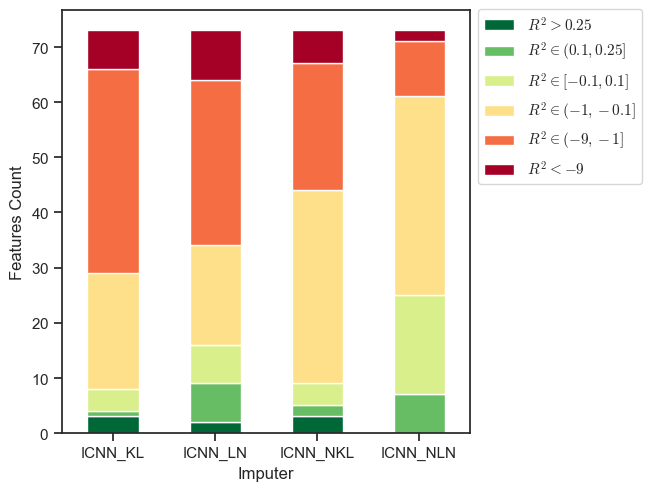

In [176]:
ax = R_bins.iloc[:4, :].plot(y=R_classes, kind="bar", rot=0, stacked=True, colormap='RdYlGn_r', ylabel='Features Count')
_ = ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left')
# ax.get_figure().set_size_inches(fig_width_in, fig_height_in)
ax.get_figure().savefig(f"{RESULTS_DIR}/{EXP}_R2_bins.pdf")

In [172]:
icnn_ = all_models_filtered_features_stats_df[all_models_filtered_features_stats_df.Imputer.str.startswith('ICNN')]
icnn_[icnn_[r'$R^2$'] < -10].groupby('Imputer')['Feature'].count()

Imputer
ICNN_KL     7
ICNN_LN     8
ICNN_NKL    6
ICNN_NLN    2
Name: Feature, dtype: int64